In [1]:
from types import SimpleNamespace
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys 
sys.path.append("../")
from source.cliploss import Loss
from source.beziercurve import BezierCurve , CurveSet
from source.diffrasterizer import rasterize_spheres
from source.utils import load_scene
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import plotly.graph_objects as go
from PIL import Image
from pathlib import Path
from PIL import Image as PILImage

save_dir = Path("training_frames")
import shutil
# remove the whole tree if it exists
if save_dir.exists():
    print("Directory already exists, wiping contents...")
    shutil.rmtree(save_dir)

# (re)create it
save_dir.mkdir(parents=True, exist_ok=True)

Directory already exists, wiping contents...


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
args = SimpleNamespace(
    device=device,
    percep_loss="none",
    train_with_clip=True,          # ✅ Enable CLIP loss
    clip_weight=1.0,               # ✅ Set a non-zero weight
    start_clip=0,
    clip_conv_loss=1,              # ✅ Enable convolutional CLIP loss
    clip_fc_loss_weight=0.1,
    clip_text_guide=0.0,
    num_aug_clip=4,
    augemntations=["affine"],
    include_target_in_aug=False,
    augment_both=False,
    clip_model_name="ViT-B/32",
    clip_conv_loss_type="L2",
    clip_conv_layer_weights=[0.1, 2.0, 1.2, 1.0, 0.0]
)

criterion = Loss(args).to(device)

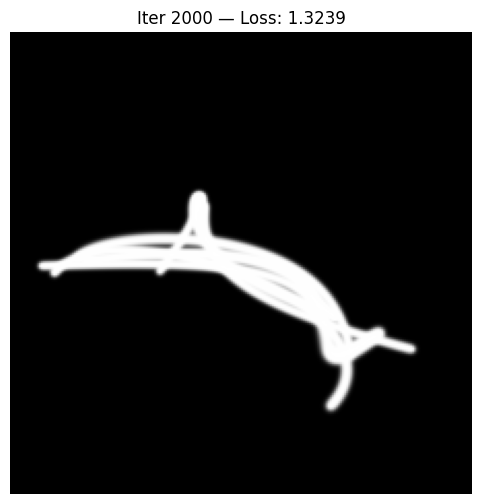

In [3]:
rasterizer = torch.compile(rasterize_spheres)
device = 'cuda'
W, H = 224, 224

# Loss and optimizer setup

# Load your scene (on CUDA)
_, c2w_all, K = load_scene("../data/transforms_train.json", W, H, device)
c2w0 = c2w_all[0]
w2c0 = torch.linalg.inv(c2w0)

# Load target image
to_tensor = T.ToTensor()
target = Image.open("../data/dolphin.png").convert("RGB")
target_t = to_tensor(target).to(device)      # (1,H,W)
target_rgb = target_t.unsqueeze(0)
target_rgb = torch.nn.functional.interpolate(target_rgb, size=(224, 224), mode='bilinear')
# Your initial control‐point tensors
alpha = 1
init_pts1 = alpha*torch.tensor([
    [-0.8,  0.6, 0.0],
    [-0.5,  1.0, 0.3],
    [ 0.2, -0.6, 0.2],
    [ 0.8, -0.4, 0.0]
], device=device)

init_pts2 = alpha*torch.tensor([
    [-0.7, -0.3, 0.0],
    [-0.4,  0.7, 0.4],
    [ 0.3, -0.5, 0.1],
    [ 0.9,  0.2, 0.0]
], device=device)

init_pts3 = alpha*torch.tensor([
    [ 0.7, -0.7, 0.0],
    [ 0.3,  0.5, 0.3],
    [-0.3, -0.6, 0.2],
    [-0.8,  0.1, 0.0]
], device=device)

init_pts4 = alpha*torch.tensor([
    [ 0.6,  0.8, 0.0],
    [ 0.0,  1.2, 0.3],
    [-0.5, -0.5, 0.2],
    [-0.9, -0.2, 0.0]
], device=device)

init_pts5 = alpha*torch.tensor([
    [ 0.7, 0.7, 0.0],
    [ 0.3,  0.5, 0.3],
    [-0.3, -0.6, 0.2],
    [-0.8,  0.1, 0.0]
], device=device)

init_pts6 = alpha*torch.tensor([
    [ 0.6,  0.8, 0.0],
    [ 0.0,  1.2, 0.3],
    [0.5, 0.5, 0.2],
    [-0.9, -0.2, 0.0]
], device=device)

# Create the CurveSet with exactly the curves you have
curve_set = CurveSet([init_pts1, init_pts2, init_pts3, init_pts4, init_pts5, init_pts6], thickness=0.015, overlap=0.6, arc_samples=300, device=device)
curve_set.to(device)

# Optimizer over all curve parameters
opt = optim.Adam(curve_set.parameters(), lr=1e-2)

# --- Live plotting setup ---
plt.ioff()
fig, ax = plt.subplots(figsize=(6, 6))
# initialize a blank image
im = ax.imshow(torch.zeros((H, W, 3), dtype=torch.float32).numpy(), vmin=0, vmax=1)
ax.axis('off')

# --- Training loop ---
num_iters = 2001
for it in range(num_iters):
    opt.zero_grad()

    # render curves: means (N,3), thicknesses (N,)
    means, thicknesses = curve_set()
    img = rasterizer(means, thicknesses, w2c0, K, W, H)   # (H,W,1)
    img = img.permute(2, 0, 1).unsqueeze(0)                # (1,1,H,W)
    img = img.repeat(1, 3, 1, 1)                           # (1,3,H,W)

    # compute loss and backprop
    loss = criterion(img, target_rgb, it)
    loss.backward()
    opt.step()

    # update display every 5 iters
    if it % 5 == 0:
        curr = img[0].permute(1, 2, 0).detach().cpu().numpy()
        im.set_data(curr)
        ax.set_title(f"Iter {it:4d} — Loss: {loss.item():.4f}")

        frame_path = save_dir / f"iter_{it:04d}.png"
        fig.canvas.draw()                        # ← add this line
        fig.savefig(frame_path,                  # use fig.savefig instead of plt.savefig
                    bbox_inches='tight',
                    pad_inches=0)

        clear_output(wait=True)
        display(fig)
        plt.pause(0.01)

# final display
plt.show()


In [4]:
from PIL import Image as PILImage

# Gather and sort saved frames
frame_paths = sorted(save_dir.glob("iter_*.png"))
frames = [PILImage.open(p) for p in frame_paths]

# Save GIF
gif_path = "training_evolution.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
print(f"GIF saved to {gif_path}")

for p in frame_paths:
    p.unlink()
save_dir.rmdir()
print("Temporary files cleaned up.")

GIF saved to training_evolution.gif
Temporary files cleaned up.


In [ ]:
plt.figure()

# Show generated image (convert to H×W×C)
plt.subplot(1, 2, 1)
img_np = img[0].permute(1, 2, 0).cpu().detach().numpy()  # (3, H, W) → (H, W, 3)
plt.imshow(img_np, vmin=0, vmax=1)
plt.title("Generated Image")
plt.axis('off')

# Show target image (convert to H×W×C)
plt.subplot(1, 2, 2)
target_np = target_rgb[0].permute(1, 2, 0).cpu().numpy()  # (3, H, W) → (H, W, 3)
plt.imshow(target_np, vmin=0, vmax=1)
plt.title("Target Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_spheres(means: np.ndarray, radii: np.ndarray, resolution: int = 20):
    """
    Plot 3D spheres centered at `means` with given `radii`.

    Args:
        means      (N,3) numpy array of sphere centers
        radii      (N,) numpy array of sphere radii
        resolution number of subdivisions in θ,ϕ (higher → smoother)
    """
    # parameterize a unit sphere
    u = np.linspace(0, 2*np.pi, resolution)
    v = np.linspace(0, np.pi,   resolution)
    uu, vv = np.meshgrid(u, v)

    fig = go.Figure()

    for (x0, y0, z0), r in zip(means, radii):
        # sphere surface at center (x0,y0,z0)
        x = x0 + r * np.cos(uu) * np.sin(vv)
        y = y0 + r * np.sin(uu) * np.sin(vv)
        z = z0 + r * np.cos(vv)

        fig.add_trace(go.Surface(
            x=x, y=y, z=z,
            showscale=False,
            opacity=0.6,
            lighting=dict(ambient=0.5, diffuse=0.5, roughness=0.9),
            hoverinfo='skip'
        ))

    # make axes equal and add some padding
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', backgroundcolor="rgb(230, 230,230)"),
            yaxis=dict(title='Y', backgroundcolor="rgb(230, 230,230)"),
            zaxis=dict(title='Z', backgroundcolor="rgb(230, 230,230)"),
            aspectmode='data'
        ),
        width=800, height=800,
        title="3D Spheres at Bézier Sample Locations"
    )

    fig.show()


# --- Example usage ---

# assuming you have your torch tensors `means` and `thicknesses` already:
import torch

# means: (N,3) tensor on CPU or GPU
# thicknesses: (N,) world‐space radii
means_np = means.detach().cpu().numpy()
radii_np = thicknesses.detach().cpu().numpy()

plot_spheres(means_np, radii_np)